# 逆行列演算なしのGP
- 通常の演算では，$K^{-1} y$のような逆行列演算が必要
- これは連立方程式$K a = y$を満たすaとみることができる
- この連立方程式は，LU分解（Kが正定値の場合はCholesky分解）で$K=LU$に分解すると，連立方程式$K a = y$は，$LUa = y$となる
  - $L$は下三角行列，$U$は上三角行列 
- そうすると，以下の2つの連立方程式を解けば，aの解を求められることが分かる
  - $L m = y$
  - $U a = m$
- $L$と$U$がそれぞれ下・上三角行列なので，2つの連立方程式の解は逆行列を使わなくとも簡単に求められる
  - $ L = \left(
        \begin{array}{rrr}
        l_{11} & 0 & \cdots \\
        l_{21} & l_{22} & 0 \\
        \vdots & \vdots & \ddots
        \end{array}
        \right)
  $， $m = (m_1, m_2 , \cdots)^T$， $y = (y_1, y_2 , \cdots)^T$の時
  - 1行目：$m_1 = \frac{y_1}{l_{11}}$となり簡単に解ける
  - 2行目：$m_2 = \frac{y_2 - l_{21} m_1}{ l_{22} }$となり，1行目の結果を代入すると解ける
  - これを繰り返すことで，$L m = y$の解$m$を逆行列なしで求められる
- numpyのsolve関数は上記のような解き方をしているので，solve関数を使うことで逆行列演算なしでGPの予測分布を計算できる

In [36]:
class GP:
  def __init__(self, dim, device="cuda" ):
    self.beta = 10.0
    self.dim = dim
    self.device = device

  def k(self, xi, xj):
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 

  def cov(self, xi, xj ):
    a = xi.view(-1,1,self.dim).repeat(1, len(xj), 1)
    b = xj.view(1,-1,self.dim).repeat(len(xi), 1, 1)
    return self.k(a,b)

  def learn(self, xt, yt ):
    self.xt = torch.tensor(xt).reshape(-1,self.dim)
    self.yt = torch.tensor(yt)
    N = len(xt)

    # to gpu
    self.xt.to(self.device)
    self.yt.to(self.device)

    # カーネル行列を定義
    self.K = self.cov( self.xt, self.xt ) + torch.eye(N, N)/self.beta

    # 逆行列は計算しない
    #self.K_inv = torch.inverse( self.K )
  
  def predict( self, x ):
    x = torch.tensor(x).reshape(-1,self.dim)

    kx = self.cov( x, self.xt )
    k = self.cov( x, x) + 1.0/self.beta

    # K a = yを満たすa（ = K^-1 y）を逆行列を使わずに解く
    a, _ = torch.solve(self.yt.reshape(-1,1) , self.K)
    mu = torch.mm( kx, a )

    # K b = kx^Tを満たすb（= K^-1 kx^T）を逆行列を使わずに解く
    b, _ = torch.solve( torch.t(kx), self.K)
    sig = k - torch.mm( kx, b )
        
    return mu.detach().numpy().flatten(), sig.diag().detach().numpy().flatten()

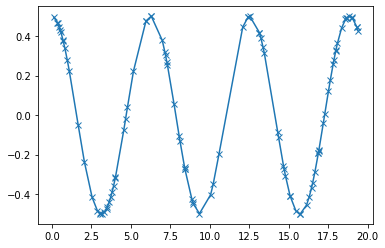

In [37]:
xt = np.sort(np.random.rand(100)*20)
yt = np.cos(xt)/2

plt.plot( xt, yt, "x-" )

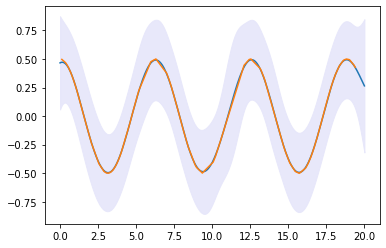

In [38]:
gp = GP(1, "cpu")
gp.learn( xt.reshape((-1,1)), yt )

x = np.linspace( 0,20,1000 )
mus, sigmas = gp.predict( x.reshape(-1,1) )

plt.plot( x, mus )

y_max = mus + np.sqrt(sigmas.flatten())
y_min = mus - np.sqrt(sigmas.flatten())

plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )
plt.plot(xt, yt)
plt.show()